## Dependencies and Packages

This notebook uses Pandas, Beautiful Soup, Requests, RegEx, Numpy, and scikit-learn.

In [152]:
import pandas as pd
import bs4
import requests
import re
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.ensemble import IsolationForest

### Data Collection

The base of our data set comes from the [NBA Players stats since 1950](https://www.kaggle.com/drgilermo/nba-players-stats) data on Kaggle. We use the player_data.csv and Seasons_stats.csv file to get a look at a player's full career. We start by loading in the player_data.csv to a pandas DataFrame and drop players with incomlpete data.

In [108]:
players_df = pd.read_csv('player_data.csv')
players_df.drop([423, 1191, 2063, 3146], inplace=True)
players_df.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


Next, we load in the seasons_stats.csv file into a pandas DataFrame and drop the unnamed additional column. Next, we drop empty rows to clean up the data and correct names of players with asterisks to clean up joins later on.

In [109]:
seasons_df = pd.read_csv('Seasons_stats.csv')
seasons_df.drop('Unnamed: 0', axis=1, inplace=True)
seasons_df.dropna(inplace=True, how='all')
seasons_df['Player'] = seasons_df['Player'].apply(lambda x: re.sub('\*', "", x))
seasons_df.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In order to summarize the seasons by player to summarize their careers, some of the stats need to be looked at as a total across the player's career while others need to be looked at as an average across the player's career. In order to do that in a single function, we create a dictionary with each column we want to summarize and whether it needs to be summarized by mean or sum and run a pandas agg function.

In [110]:
agg_dict = {'PER': ['mean'], 'TS%': ['mean'], '3PAr': ['mean'], 'FTr': ['mean'], 'ORB%': ['mean'], 'DRB%': ['mean'], 
            'TRB%':['mean'], 'AST%': ['mean'], 'STL%': ['mean'], 'BLK%': ['mean'], 'TOV%': ['mean'], 'USG%': ['mean'],
            'WS/48': ['mean'], 'OBPM': ['mean'], 'DBPM': ['mean'], 'BPM': ['mean'], 'FG%':['mean'], '3P%': ['mean'], 
            '2P%': ['mean'], 'eFG%': ['mean'], 'FT%': ['mean'], 'G': ['sum'], 'GS': ['sum'], 'MP': ['sum'], 
            'OWS': ['sum'], 'DWS': ['sum'], 'WS': ['sum'], 'FG': ['sum'], 'FGA': ['sum'], '3P': ['sum'], '3PA': ['sum'],
            '2P': ['sum'], '2PA': ['sum'], 'FT': ['sum'], 'FTA': ['sum'], 'ORB': ['sum'], 'DRB': ['sum'], 'TRB': ['sum'],
            'AST': ['sum'], 'STL': ['sum'], 'BLK': ['sum'], 'TOV': ['sum'], 'PF': ['sum'], 'PTS': ['sum']}

In [111]:
seasons_agg_df = seasons_df.groupby(['Player']).agg(agg_dict)
seasons_agg_df.columns = seasons_agg_df.columns.droplevel(1)
seasons_agg_df.head()

,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,...,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green,13.872222,0.543556,0.049,0.437111,10.388889,18.811111,14.655556,5.216667,1.438889,0.85,...,4447.0,3576.0,6553.0,10129.0,1469.0,1103.0,562.0,1508.0,2581.0,12928.0
A.J. Bramlett,-0.400000,0.190000,0.000,0.000000,21.700000,18.500000,20.100000,0.000000,0.800000,0.00,...,0.0,12.0,10.0,22.0,0.0,1.0,0.0,3.0,13.0,8.0
A.J. English,11.550000,0.480000,0.047,0.241000,4.900000,6.250000,5.550000,15.850000,0.900000,0.45,...,333.0,140.0,175.0,315.0,320.0,57.0,24.0,203.0,287.0,1502.0
A.J. Guyton,4.366667,0.324000,0.371,0.068333,1.366667,3.800000,2.533333,23.466667,2.466667,0.50,...,45.0,22.0,58.0,80.0,147.0,20.0,12.0,62.0,58.0,442.0
A.J. Hammons,8.400000,0.472000,0.238,0.476000,5.400000,20.900000,12.800000,3.800000,0.300000,7.20,...,20.0,8.0,28.0,36.0,4.0,1.0,13.0,10.0,21.0,48.0


Next we edit down the player_df to the columns that we care about, the name, start of the career, end of the career, and position of the player to join to the summary of the player careers. To make the join simpler, we set the index of the player DataFrame to the player name.

In [112]:
edited_player_df = players_df[['name', 'year_start', 'year_end', 'position']]
edited_player_df.rename(columns={'name': 'Player'}, inplace=True)
edited_player_df.set_index('Player', inplace=True)
edited_player_df.head()

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,year_start,year_end,position
Player,,,
Alaa Abdelnaby,1991,1995,F-C
Zaid Abdul-Aziz,1969,1978,C-F
Kareem Abdul-Jabbar,1970,1989,C
Mahmoud Abdul-Rauf,1991,2001,G
Tariq Abdul-Wahad,1998,2003,F


Finally, we join both DataFrames by the player name and create our base dataset for analysis.

In [113]:
dataset_df = edited_player_df.join(seasons_agg_df, on='Player', how='inner')
dataset_df

,year_start,year_end,position,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
Alaa Abdelnaby,1991,1995,F-C,9.833333,0.475889,0.004222,0.244000,9.788889,19.700000,14.766667,...,472.0,446.0,851.0,1297.0,125.0,111.0,107.0,389.0,777.0,2299.0
Zaid Abdul-Aziz,1969,1978,C-F,13.750000,0.450071,NaN,0.345857,15.171429,25.400000,19.210000,...,1536.0,522.0,1155.0,4524.0,648.0,134.0,208.0,28.0,1264.0,4978.0
Kareem Abdul-Jabbar,1970,1989,C,24.085000,0.591500,0.001800,0.325100,7.618750,21.125000,15.305263,...,9304.0,2975.0,9394.0,17440.0,5660.0,1160.0,3189.0,2527.0,4657.0,38387.0
Mahmoud Abdul-Rauf,1991,2001,G,14.877778,0.497111,0.158778,0.134667,1.477778,6.111111,3.744444,...,1161.0,219.0,868.0,1087.0,2079.0,487.0,46.0,963.0,1106.0,8553.0
Tariq Abdul-Wahad,1998,2003,F,9.930000,0.410100,0.033200,0.296900,7.310000,12.120000,9.700000,...,755.0,428.0,723.0,1151.0,388.0,263.0,121.0,442.0,688.0,2662.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stephen Zimmerman,2017,2017,C,7.300000,0.346000,0.000000,0.161000,10.800000,24.900000,17.600000,...,5.0,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
Paul Zipser,2017,2018,G-F,6.900000,0.503000,0.448000,0.181000,1.900000,14.200000,8.000000,...,40.0,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0
Jim Zoet,1983,1983,C,-0.800000,0.200000,0.000000,0.000000,10.200000,17.700000,13.900000,...,0.0,3.0,5.0,8.0,1.0,1.0,3.0,4.0,9.0,2.0


#### Hall of Fame

Next, we'll create our target variable by scraping [Basketball Real GM's Hall of Fame List](https://basketball.realgm.com/nba/hall-of-fame) using BeautifulSoup to get the list of current hall of fame players.

In [114]:
hof_url = 'https://basketball.realgm.com/nba/hall-of-fame'
hof_page = requests.get(hof_url)
hof_soup = bs4.BeautifulSoup(hof_page.content, 'html.parser')
hof_players = []
for player in hof_soup.find_all(href=re.compile("/player/")):
    hof_players.append(player.text)

Next, we'll create a helper function to set which players are hall of famers and which are not.

In [115]:
def hall_of_fame(name):
    if name in hof_players:
        return 'Yes'
    else:
        return 'No'

dataset_df['Hall of Fame'] = [hall_of_fame(name) for name in dataset_df.index]

#### All NBA
One of the key ways to identify who was one of the best players every year is to look at the All NBA team that is chosen every year. Over the years, there has been more choices added, but it is still held as one of the best standards to see who's the best of the best. We'll get this information by scraping the [NBA's record of All NBA teams](https://www.nba.com/history/awards/all-nba-team) and dividing them by First Team, Second Team, and Third Team. We'll then add a tally for each time a player made a First Team, Second Team, or Third Team to our overall data set.

In [116]:
all_nba_url = 'https://www.nba.com/history/awards/all-nba-team'
all_nba_page = requests.get(all_nba_url)
all_nba_soup = bs4.BeautifulSoup(all_nba_page.content, 'html.parser')

In [117]:
test_year = all_nba_soup.find('h3', string='2016-17')
all_nba_dict = {'FIRST TEAM': [], 'SECOND TEAM': [], 'THIRD TEAM': []}
team = ''
for sibling in test_year.next_siblings:
    if sibling.string and sibling.string in ['FIRST TEAM', 'SECOND TEAM', 'THIRD TEAM']:
        team = sibling.string
        for tag in sibling.next_sibling.children:
            if tag.string and tag.string.strip() in ['C:', 'F:', 'G:']:
                continue
            elif tag.string and tag.string.strip():
                if tag.string.strip().find(',') != -1:
                    end = tag.string.strip().find(',')
                    all_nba_dict[team].append(tag.string.strip()[0:end])
                else: 
                    all_nba_dict[team].append(tag.string.strip())

In [118]:
for key in all_nba_dict.keys():
    name = 'All NBA ' + key
    dataset_df[name] = 0
    for player in all_nba_dict[key]:
        if player in dataset_df.index:
            dataset_df[name][player] += 1

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### MVP

The NBA's Most Valuable Player Award is given to the best player every season. While it is not a requirement to get into the Hall of Fame, winning an MVP award is a good indication of a player being a Hall of Fame calibre player. Many Hall of Fame players have won multiple MVP's in their careers. We'll scrape the [NBA's Record of MVPs](https://www.nba.com/history/awards/mvp) and process the results to create a list of MVP's for all the years in our data. Next, we'll add the total for each player to their row in our dataset for each MVP award they won.

In [119]:
mvp_url = 'https://www.nba.com/history/awards/mvp'
mvp_page = requests.get(mvp_url)
mvp_soup = bs4.BeautifulSoup(mvp_page.content, 'html.parser')

In [120]:
mvp_list = mvp_soup.find("p").next_sibling.next_sibling
mvps = []
for string in mvp_list.stripped_strings:
    string = string.replace("\xa0", "")
    if "2018-19" in string:
        continue
    if "2017-18" in string:
        continue
    if re.findall("\d{4}\-\d{2}", string):
        string = re.split("\d{4}\-\d{2}", string)[1].strip()
        end = string.index(",")
        mvps.append(string[0:end])

In [121]:
dataset_df['MVP'] = 0
for player in mvps:
    dataset_df['MVP'][player] += 1

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### All Star Game Appearances

The All Star Game is an alternative to the All NBA team selection, while the All NBA team is chosen by a select group of media members, All Star Game starters are chosen by fans. All Star selections are a great way to measure a player's influence and popularity, which can impact a player's chance to get into the Hall of Fame. We'll start by scraping [Wikipedia's list of NBA All Stars](https://en.wikipedia.org/wiki/List_of_NBA_All-Stars) and adding the total number of all star selections for each player to the dataset.

In [122]:
all_star_url = "https://en.wikipedia.org/wiki/List_of_NBA_All-Stars"
all_star_page = requests.get(all_star_url)
all_star_soup = bs4.BeautifulSoup(all_star_page.content, 'html.parser')
rows = all_star_soup.find_all('tr')

In [123]:
dataset_df['All Star Games'] = 0
for row in rows:
    if row.find_all("span", attrs={"class": "fn"}):
        name = re.sub("\s", " ", row.find("span", attrs={"class": "fn"}).string)
        if name in dataset_df.index:
            dataset_df['All Star Games'][name] = row.contents[3].string
            if "DeAndre Jordan" in name:
                print(name, row.contents[3].string, dataset_df['All Star Games'][name])

DeAndre Jordan 1 1


/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [124]:
for row in rows:
    if row.find_all("span", attrs={"class": "fn"}):
        name = re.sub("\s", " ", row.find("span", attrs={"class": "fn"}).string)
        if name in dataset_df.index:
            dataset_df['All Star Games'][name] = row.contents[3].string

DeAndre Jordan 1 1


/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [181]:
dataset_df.loc["Mike Dunleavy"]

,year_start,year_end,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,All NBA THIRD TEAM,MVP,All Star Games,Championships,C-F,F,F-C,F-G,G,G-F
Player,,,,,,,,,,,,,,,,,,,,,
Mike Dunleavy,1977,1990,13.5,0.549594,0.407481,0.278375,2.209375,10.865625,6.51875,18.221875,...,0,0,0,0,0,0,0,0,1,0
Mike Dunleavy,2003,2017,13.5,0.549594,0.407481,0.278375,2.209375,10.865625,6.51875,18.221875,...,0,0,0,0,0,0,0,1,0,0


#### Championships

Many people argue that a hall of fame player needs at least one championship in order to solidify their resume. The line between players of similar skill who get in versus peopple who don't often can come down to whether the player has a championship on their resume or not. We'll add the number of championships each player earned by scraping [Basketball-Reference](https://www.basketball-reference.com/leagues/) which keeps a record of each championship winning team as well as their roster to add up how many championships each player won and add them to the dataset.

In [126]:
seasons_url = "https://www.basketball-reference.com/leagues/"
seasons_page = requests.get(seasons_url)
seasons_soup = bs4.BeautifulSoup(seasons_page.content, 'html.parser')

In [127]:
dataset_df['Championships'] = 0
base_url = 'https://www.basketball-reference.com'
champions = seasons_soup.find_all('td', attrs={"data-stat": "champion"})
for champion in champions:
    if champion.find('a'):
        if '2019' in champion.find('a')['href']:
            continue
        if '2018' in champion.find('a')['href']:
            continue
        sub_url = base_url + champion.find('a')['href']
        sub_page = requests.get(sub_url)
        sub_soup = bs4.BeautifulSoup(sub_page.content, 'html.parser')
        player_list = sub_soup.find_all('td', attrs={'data-stat': 'player'})
        for player in player_list:
            if player.string in dataset_df.index:
                dataset_df['Championships'][player.string] += 1

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


#### Final Data Processing

Our final data processing will be to fill every blank stat with a 0, as most of these stats that are blank are from before these stats were tracked. We also make player position a categorical variable that may influence how stats like assists, rebounds, and points are interpreted.

In [129]:
dataset_df.fillna(0, inplace=True)
dataset_df.isna().sum()

year_start             0
year_end               0
position               0
PER                    0
TS%                    0
3PAr                   0
FTr                    0
ORB%                   0
DRB%                   0
TRB%                   0
AST%                   0
STL%                   0
BLK%                   0
TOV%                   0
USG%                   0
WS/48                  0
OBPM                   0
DBPM                   0
BPM                    0
FG%                    0
3P%                    0
2P%                    0
eFG%                   0
FT%                    0
G                      0
GS                     0
MP                     0
OWS                    0
DWS                    0
WS                     0
FG                     0
FGA                    0
3P                     0
3PA                    0
2P                     0
2PA                    0
FT                     0
FTA                    0
ORB                    0
DRB                    0


In [131]:
dataset_df['position']['George Karl'] = 'G'
dataset_df['position'].astype('category')
dummy_df = pd.get_dummies(dataset_df['position'], drop_first=True)
dummy_df
dataset_df = pd.concat([dataset_df, dummy_df], axis=1)
dataset_df.drop(['position'], axis=1, inplace=True)
dataset_df

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,year_start,year_end,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,All NBA THIRD TEAM,MVP,All Star Games,Championships,C-F,F,F-C,F-G,G,G-F
Player,,,,,,,,,,,,,,,,,,,,,
Alaa Abdelnaby,1991,1995,9.833333,0.475889,0.004222,0.244000,9.788889,19.700000,14.766667,4.244444,...,0,0,0,0,0,0,1,0,0,0
Zaid Abdul-Aziz,1969,1978,13.750000,0.450071,0.000000,0.345857,15.171429,25.400000,19.210000,7.564286,...,0,0,0,0,1,0,0,0,0,0
Kareem Abdul-Jabbar,1970,1989,24.085000,0.591500,0.001800,0.325100,7.618750,21.125000,15.305263,14.235000,...,0,6,19,6,0,0,0,0,0,0
Mahmoud Abdul-Rauf,1991,2001,14.877778,0.497111,0.158778,0.134667,1.477778,6.111111,3.744444,23.444444,...,0,0,0,0,0,0,0,0,1,0
Tariq Abdul-Wahad,1998,2003,9.930000,0.410100,0.033200,0.296900,7.310000,12.120000,9.700000,9.750000,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stephen Zimmerman,2017,2017,7.300000,0.346000,0.000000,0.161000,10.800000,24.900000,17.600000,5.300000,...,0,0,0,0,0,0,0,0,0,0
Paul Zipser,2017,2018,6.900000,0.503000,0.448000,0.181000,1.900000,14.200000,8.000000,6.100000,...,0,0,0,0,0,0,0,0,0,1
Jim Zoet,1983,1983,-0.800000,0.200000,0.000000,0.000000,10.200000,17.700000,13.900000,3.800000,...,0,0,0,0,0,0,0,0,0,0


### Training our Models

First, let's separate any player whose career did not end before 2017, as they are not eligible for the NBA Hall of Fame. We'll use this data set to see who is a current player that has reached hall of fame status for their career. Next, we'll use the players who have been retired long enough to be Hall of Fame eligible to train and evaluate our model options.

In [158]:
predict_df = dataset_df[dataset_df['year_end'] >= 2017]

In [159]:
train_df = dataset_df[dataset_df['year_end'] < 2017]
train_df['Hall of Fame']['Kevin Garnett'] = 'Yes'
train_df['Hall of Fame']['Kobe Bryant'] = 'Yes'
train_df['Hall of Fame']['Tim Duncan'] = 'Yes'

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


### First Models: Logistic Regression, Support Vector Classification, and Decision Tree

We'll start by splitting our training data into a 80/20 train/test split. Next, we'll set up the classifiers in a list for our Pipeline to try. We will also feed the Pipeline different hyperparameters for each model, including ones that will help balance the class imbalance from there being so many more players who didn't make the Hall of Fame than who did.

In [26]:
X = train_df.drop(['Hall of Fame'], axis=1)
y = train_df['Hall of Fame']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
random_state = 4
classifiers = [LogisticRegression(random_state=random_state), 
               SVC(random_state=random_state), 
               DecisionTreeClassifier(random_state=random_state)]
params = [
    {'clf__C':[0.25, 0.50, 0.75, 1.0],
     'clf__class_weight': [None, 'balanced', {'Yes':2, 'No':1}, {'Yes':10, 'No':1}, {'Yes':100, 'No':1}, {'Yes':1000, 'No':1}]},
    
    {'clf__kernel': ['poly', 'sigmoid'],
     'clf__C': [0.01, 1, 100],
     'clf__degree': [2,3,4,5],
     'clf__gamma': [0.001, 0.01]},
    
    {'clf__criterion':['gini','entropy'],
     'clf__max_depth':[1,2,3,4],
     'clf__min_impurity_decrease':[0, 0.25, 0.50, 0.75]}
]

Next, we'll set up our pipeline to test all three classification models. We'll include a standard scaler and a Principal Component Analysis to help preprocess the data to help our classifiers be more accurate. Then we will use a gridsearch to see which combination of parameters yields the best results.

In [27]:
pipelines = []
best_clfs = []
for clf,param in zip(classifiers,params):
    pipe = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=2)),
                     ('clf', clf)])
    gs = GridSearchCV(estimator=pipe,
                  param_grid=param,
                  scoring='f1_weighted',
                  cv=3)
    gs.fit(X_train, y_train)
    best_clfs.append(gs.best_estimator_)
    pipelines.append(pipe)  
    print(clf.__class__.__name__)
    print('Best params:', gs.best_params_)
    print('Train Accuracy:',gs.best_estimator_.score(X_train, y_train))
    print('Test Accuracy:',gs.best_estimator_.score(X_test, y_test))
    print('')

LogisticRegression
Best params: {'clf__C': 0.75, 'clf__class_weight': {'Yes': 2, 'No': 1}}
Train Accuracy: 0.9771075581395349
Test Accuracy: 0.9782293178519593

SVC
Best params: {'clf__C': 100, 'clf__degree': 3, 'clf__gamma': 0.01, 'clf__kernel': 'poly'}
Train Accuracy: 0.9803779069767442
Test Accuracy: 0.9782293178519593

DecisionTreeClassifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_impurity_decrease': 0}
Train Accuracy: 0.9847383720930233
Test Accuracy: 0.9738751814223512



All of our models perform well on the surface with the f1 score. When we look at the confusion matrix below, we can see that our best performing models perform at 40% accuracy with the class that we care about, who had a Hall of Fame career

In [28]:
confusion_matrix(y_test, best_clfs[1].predict(X_test))

array([[664,   0],
       [ 15,  10]])

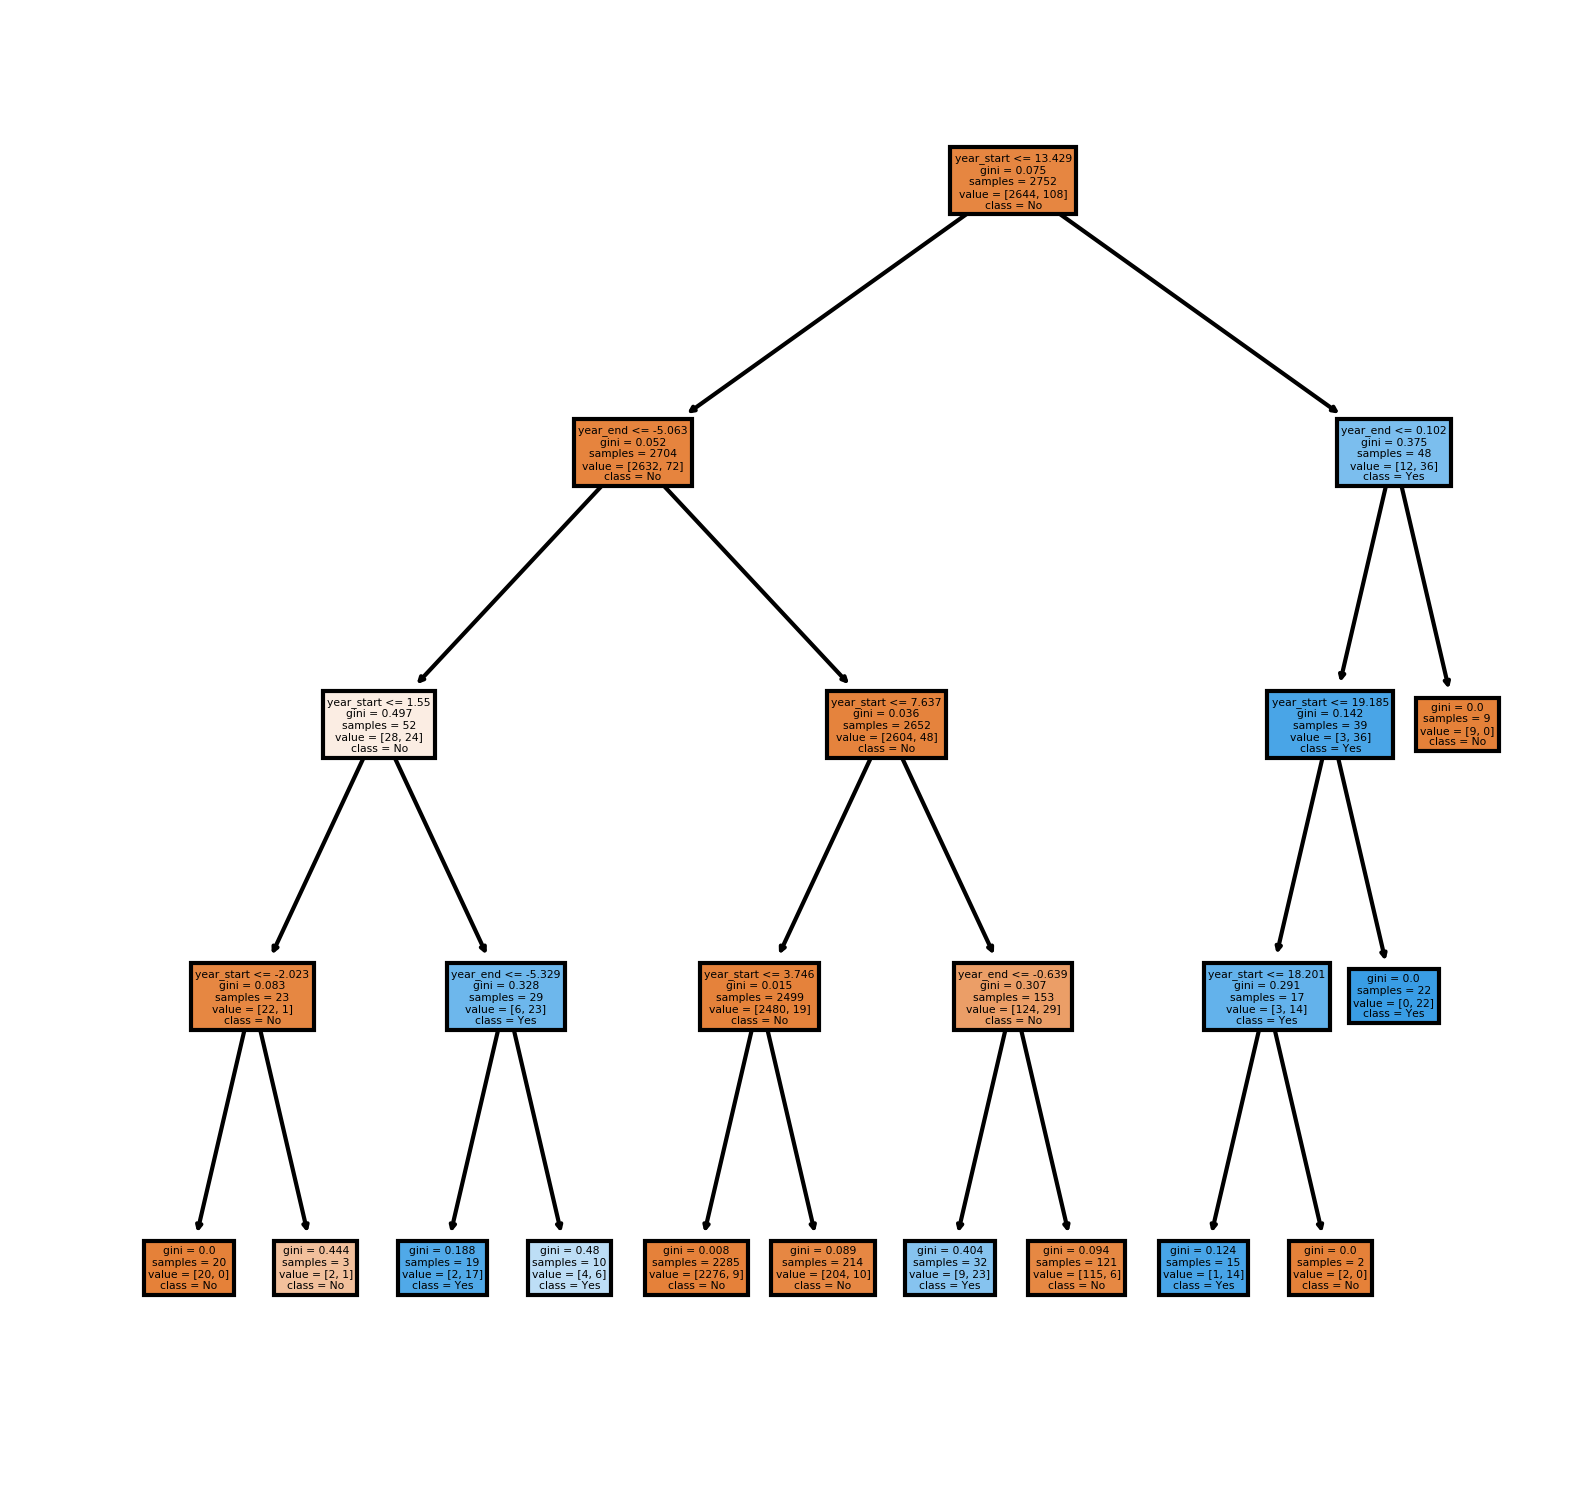

In [29]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=300)
plot_tree(best_clfs[2].steps[2][1], feature_names=X_test.columns, class_names=y_test.unique(), filled=True);

When we look at the decision tree mapped out, we can see that duration of a player's career seems to be the biggest influence on the models. So let's remove the stats that look at the duration of a player's career and remove them from our model.

In [30]:
X = train_df.drop(['Hall of Fame', 'year_start', 'year_end', 'G', 'GS', 'MP'], axis=1)
y = train_df['Hall of Fame']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
random_state = 4
classifiers = [LogisticRegression(random_state=random_state), 
               SVC(random_state=random_state), 
               DecisionTreeClassifier(random_state=random_state)]
params = [
    {'clf__C':[0.25, 0.50, 0.75, 1.0],
     'clf__class_weight': [None, 'balanced', {'Yes':2, 'No':1}, {'Yes':10, 'No':1}, {'Yes':100, 'No':1}, {'Yes':1000, 'No':1}]},
    
    {'clf__kernel': ['poly', 'sigmoid'],
     'clf__C': [0.01, 1, 100],
     'clf__degree': [2,3,4,5],
     'clf__gamma': [0.001, 0.01]},
    
    {'clf__criterion':['gini','entropy'],
     'clf__max_depth':[1,2,3,4],
     'clf__min_impurity_decrease':[0, 0.25, 0.50, 0.75]}
]

In [31]:
pipelines = []
best_clfs = []
for clf,param in zip(classifiers,params):
    pipe = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=2)),
                     ('clf', clf)])
    gs = GridSearchCV(estimator=pipe,
                  param_grid=param,
                  scoring='f1_weighted',
                  cv=3)
    gs.fit(X_train, y_train)
    best_clfs.append(gs.best_estimator_)
    pipelines.append(pipe)  
    print(clf.__class__.__name__)
    print('Best params:', gs.best_params_)
    print('Train Accuracy:',gs.best_estimator_.score(X_train, y_train))
    print('Test Accuracy:',gs.best_estimator_.score(X_test, y_test))
    print('')

LogisticRegression
Best params: {'clf__C': 0.25, 'clf__class_weight': {'Yes': 2, 'No': 1}}
Train Accuracy: 0.9752906976744186
Test Accuracy: 0.969521044992743

SVC
Best params: {'clf__C': 100, 'clf__degree': 3, 'clf__gamma': 0.01, 'clf__kernel': 'poly'}
Train Accuracy: 0.9767441860465116
Test Accuracy: 0.9796806966618288

DecisionTreeClassifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_impurity_decrease': 0}
Train Accuracy: 0.9789244186046512
Test Accuracy: 0.9782293178519593



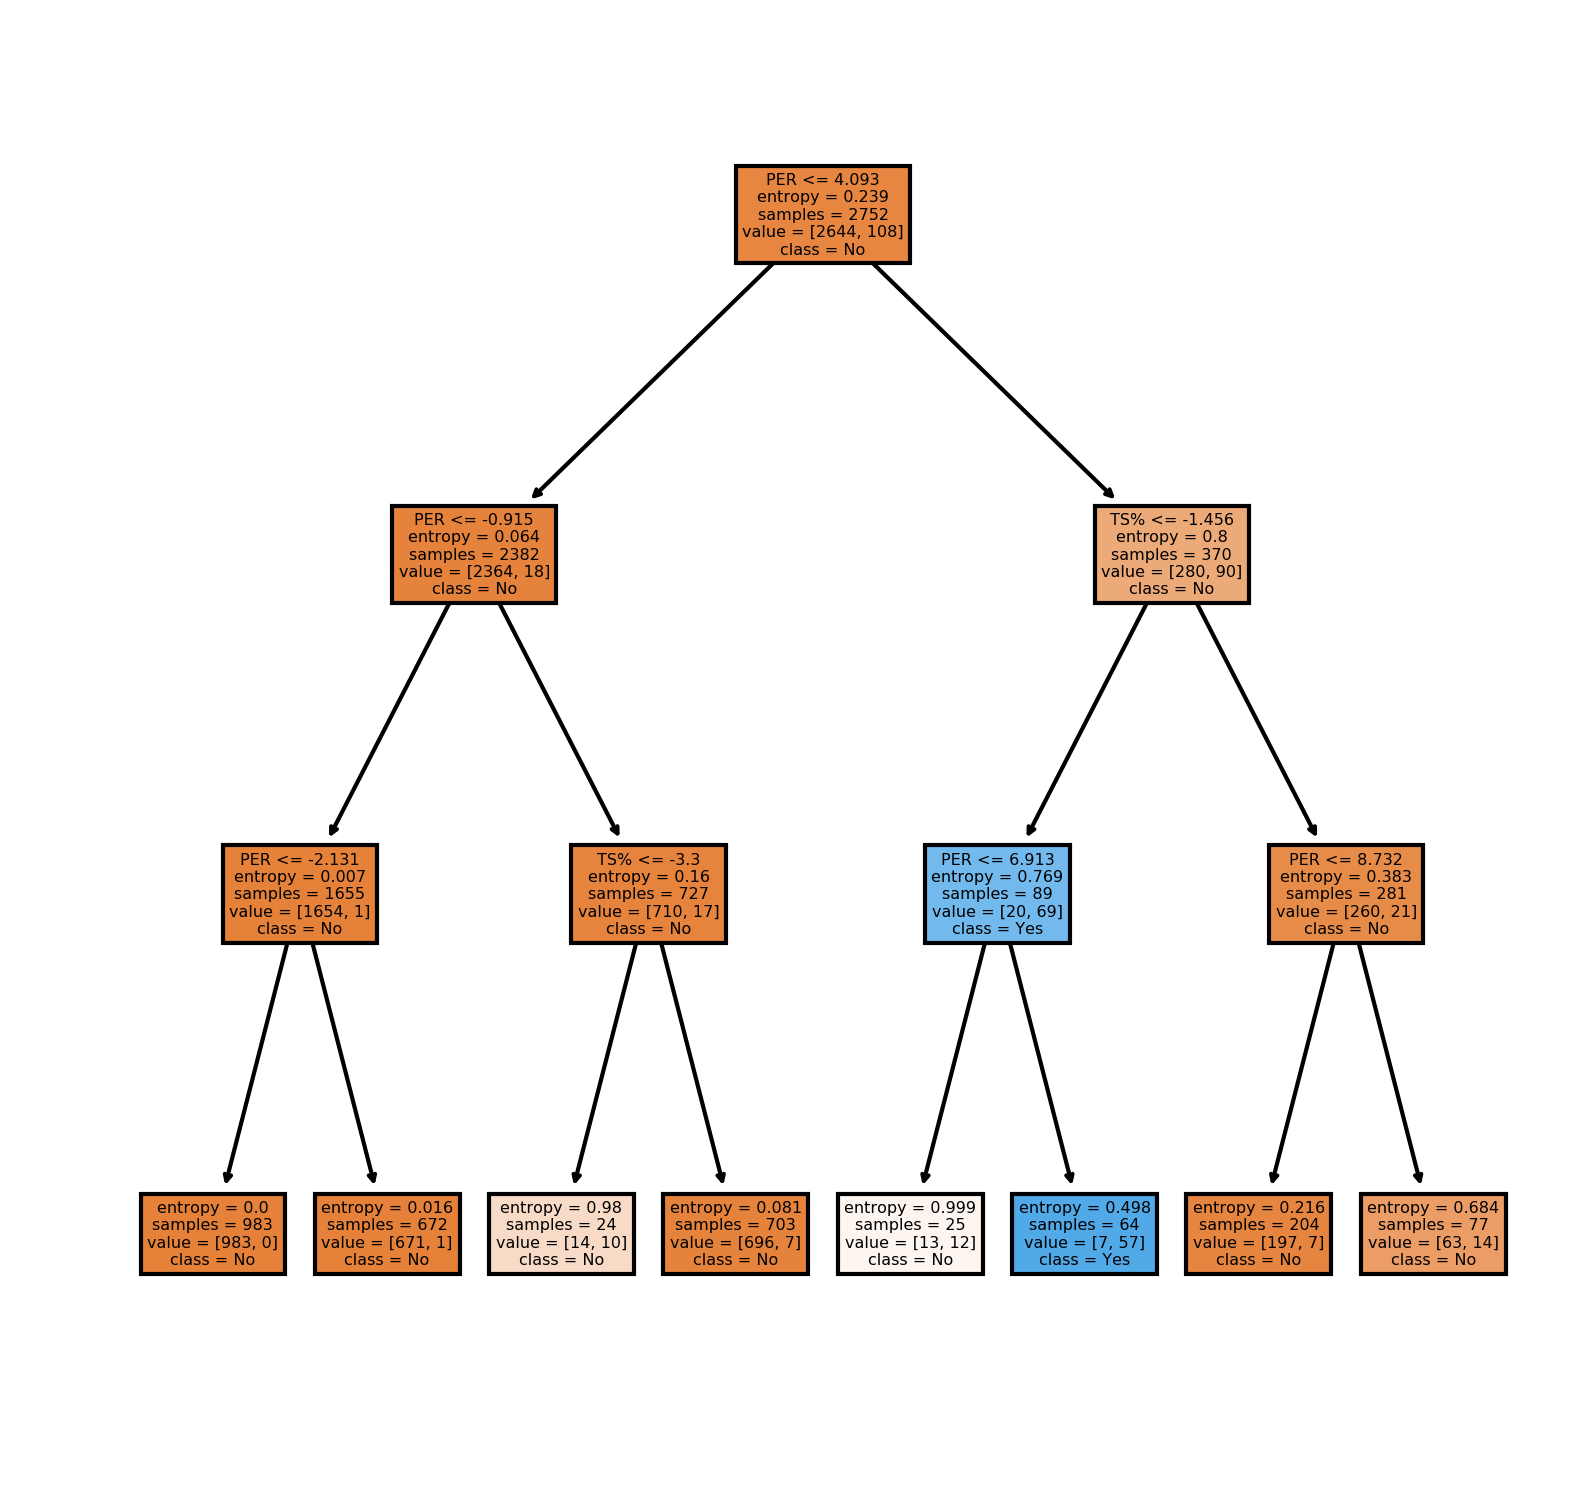

In [32]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=300)
plot_tree(best_clfs[2].steps[2][1], feature_names=X_test.columns, class_names=y_test.unique(), filled=True);

In [33]:
confusion_matrix(y_test, best_clfs[2].predict(X_test))

array([[664,   0],
       [ 15,  10]])

Removing the duration of career stats did not influence the overall performance of our models to accurately predict Hall of Fame Careers.

### Anomaly Detection: OneClassSVM and Isolation Forest

One way to look at an NBA Hall of Fame career is as an anomaly that needs to be detected. Only 3.7% of players make the Hall of Fame, which means that the classes are so imbalanced, that anomaly detection might be the best approach. We'll set up our training data set to be compatible with anomaly detection models and plug them into our Pipeline again.

In [160]:
classifier = OneClassSVM()
params = {'kernel' : ['rbf', 'sigmoid', 'linear', 'poly'],
          'nu' : [0.1, 0.3, 0.5, 0.7, 0.9]
         }
svm_X = train_df
svm_y = train_df['Hall of Fame']
svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X, svm_y, test_size=0.2, random_state=42)
svm_X_train = svm_X_train[svm_X_train['Hall of Fame'] == 'No'].drop(['Hall of Fame'], axis=1)
svm_X_test = svm_X_test.drop(['Hall of Fame'], axis=1)
svm_y_test[svm_y_test == 'Yes'] = -1
svm_y_test[svm_y_test == 'No'] = 1
svm_y_test = np.array(svm_y_test)
grid = ParameterGrid(params)

In [35]:
models = []
for param_set in grid:
    pipe = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=2)),
                     ('clf', OneClassSVM(kernel = param_set['kernel'], nu = param_set['nu']))])
    pipe.fit(svm_X_train)
    y_pred = pipe.predict(svm_X_test)
    print('Parameter Set: ', param_set)
    print('F1 Score: ', f1_score(svm_y_test.astype(int), y_pred, pos_label=-1))
    models.append(pipe)

Parameter Set:  {'kernel': 'rbf', 'nu': 0.1}
F1 Score:  0.2857142857142857
Parameter Set:  {'kernel': 'rbf', 'nu': 0.3}
F1 Score:  0.1968503937007874
Parameter Set:  {'kernel': 'rbf', 'nu': 0.5}
F1 Score:  0.12919896640826875
Parameter Set:  {'kernel': 'rbf', 'nu': 0.7}
F1 Score:  0.09541984732824428
Parameter Set:  {'kernel': 'rbf', 'nu': 0.9}
F1 Score:  0.07598784194528875
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.1}
F1 Score:  0.2040816326530612
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.3}
F1 Score:  0.13973799126637554
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.5}
F1 Score:  0.1142857142857143
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.7}
F1 Score:  0.09034907597535935
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.9}
F1 Score:  0.07763975155279502
Parameter Set:  {'kernel': 'linear', 'nu': 0.1}
F1 Score:  0.017064846416382253
Parameter Set:  {'kernel': 'linear', 'nu': 0.3}
F1 Score:  0.14860681114551086
Parameter Set:  {'kernel': 'linear', 'nu': 0.5}
F1 Score:  0.2588

In [36]:
confusion_matrix(svm_y_test.astype(int), models[0].predict(svm_X_test))

array([[ 15,  10],
       [ 65, 599]])

The OneClassSVM does not perform as well as the other models.

In [37]:
models = []
for param_set in grid:
    pipe = Pipeline([('scl', StandardScaler()),
                     ('clf', OneClassSVM(kernel = param_set['kernel'], nu = param_set['nu']))])
    pipe.fit(svm_X_train)
    y_pred = pipe.predict(svm_X_test)
    print('Parameter Set: ', param_set)
    print('F1 Score: ', f1_score(svm_y_test.astype(int), y_pred, pos_label=-1))
    models.append(pipe)
confusion_matrix(svm_y_test.astype(int), models[0].predict(svm_X_test))

Parameter Set:  {'kernel': 'rbf', 'nu': 0.1}
F1 Score:  0.31496062992125984
Parameter Set:  {'kernel': 'rbf', 'nu': 0.3}
F1 Score:  0.1703703703703704
Parameter Set:  {'kernel': 'rbf', 'nu': 0.5}
F1 Score:  0.1206030150753769
Parameter Set:  {'kernel': 'rbf', 'nu': 0.7}
F1 Score:  0.09345794392523364
Parameter Set:  {'kernel': 'rbf', 'nu': 0.9}
F1 Score:  0.078125
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.1}
F1 Score:  0.22857142857142856
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.3}
F1 Score:  0.1415929203539823
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.5}
F1 Score:  0.10242587601078168
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.7}
F1 Score:  0.09090909090909091
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.9}
F1 Score:  0.07824726134585289
Parameter Set:  {'kernel': 'linear', 'nu': 0.1}
F1 Score:  0.061135371179039305
Parameter Set:  {'kernel': 'linear', 'nu': 0.3}
F1 Score:  0.021333333333333333
Parameter Set:  {'kernel': 'linear', 'nu': 0.5}
F1 Score:  0.0288461538461

array([[ 20,   5],
       [ 82, 582]])

Removing the PCA, our model performs much better than previously, Now, our model performs at 80% for Hall of Fame Predictions, however the overall accuracy is hurt by the number of false positives predicted as well.

In [38]:
models = []
for param_set in grid:
    pipe = Pipeline([('clf', OneClassSVM(kernel = param_set['kernel'], nu = param_set['nu']))])
    pipe.fit(svm_X_train)
    y_pred = pipe.predict(svm_X_test)
    print('Parameter Set: ', param_set)
    print('F1 Score: ', f1_score(svm_y_test.astype(int), y_pred, pos_label=-1))
    models.append(pipe)
confusion_matrix(svm_y_test.astype(int), models[0].predict(svm_X_test))

Parameter Set:  {'kernel': 'rbf', 'nu': 0.1}
F1 Score:  0.3148148148148148
Parameter Set:  {'kernel': 'rbf', 'nu': 0.3}
F1 Score:  0.17670682730923695
Parameter Set:  {'kernel': 'rbf', 'nu': 0.5}
F1 Score:  0.13150684931506848
Parameter Set:  {'kernel': 'rbf', 'nu': 0.7}
F1 Score:  0.09177820267686426
Parameter Set:  {'kernel': 'rbf', 'nu': 0.9}
F1 Score:  0.07645259938837921
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.1}
F1 Score:  0.02352941176470588
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.3}
F1 Score:  0.008733624454148471
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.5}
F1 Score:  0.005494505494505495
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.7}
F1 Score:  0.008213552361396302
Parameter Set:  {'kernel': 'sigmoid', 'nu': 0.9}
F1 Score:  0.018838304552590265
Parameter Set:  {'kernel': 'linear', 'nu': 0.1}
F1 Score:  0.02352941176470588
Parameter Set:  {'kernel': 'linear', 'nu': 0.3}
F1 Score:  0.008733624454148471
Parameter Set:  {'kernel': 'linear', 'nu': 0.5}
F1 Score: 

array([[ 17,   8],
       [ 66, 598]])

We get similar results removing the Standard Scaler as well.

#### Isolation Forest
Next, we'll look at Isolation Forest for anomaly detection.

In [39]:
pipe = Pipeline([('scl', StandardScaler()),
                 ('pca', PCA(n_components=2)),
                 ('clf', IsolationForest())])
pipe.fit(svm_X_train)
y_pred = pipe.predict(svm_X_test)
print('F1 Score: ', f1_score(svm_y_test.astype(int), y_pred, pos_label=-1))

F1 Score:  0.2485207100591716


In [40]:
confusion_matrix(svm_y_test.astype(int), pipe.predict(svm_X_test))

array([[ 21,   4],
       [123, 541]])

In [161]:
best_forest = IsolationForest()
best_forest.fit(svm_X_train)
y_pred = best_forest.predict(svm_X_test)
print('F1 Score: ', f1_score(svm_y_test.astype(int), y_pred, pos_label=-1))

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


F1 Score:  0.37623762376237624


/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [42]:
confusion_matrix(svm_y_test.astype(int), best_forest.predict(svm_X_test))

array([[ 18,   7],
       [ 53, 611]])

In [162]:
best_forest = IsolationForest()
best_forest.fit(svm_X_train)
y_pred = best_forest.predict(svm_X_test)
print('F1 Score: ', f1_score(svm_y_test.astype(int), y_pred, pos_label=-1))

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


F1 Score:  0.3838383838383838


/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [163]:
confusion_matrix(svm_y_test.astype(int), best_forest.predict(svm_X_test))

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


array([[ 19,   6],
       [ 55, 609]])

The best model we have seen so far, balancing the ability to predict the class we care about, Hall of Famers, and the number of false positives is the Isolation Forest with no Scaler or PCA. We'll look deeper into these results to understand them better.

In [135]:
y_pred = best_forest.predict(svm_X_test)

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [136]:
svm_X_test

,year_start,year_end,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,All NBA THIRD TEAM,MVP,All Star Games,Championships,C-F,F,F-C,F-G,G,G-F
Player,,,,,,,,,,,,,,,,,,,,,
Pat Frink,1969,1969,7.900000,0.385000,0.000000,0.197000,0.000000,0.000000,0.000000,19.900000,...,0,0,0,0,0,0,0,0,1,0
John Amaechi,1996,2003,6.700000,0.435800,0.004200,0.486400,6.240000,13.000000,9.600000,6.960000,...,0,0,0,0,1,0,0,0,0,0
Dan Godfread,1991,1992,10.150000,0.472000,0.083000,0.333000,0.000000,6.200000,2.900000,0.000000,...,0,0,0,0,0,0,0,0,0,0
Cal Bowdler,2000,2002,11.733333,0.470333,0.027333,0.317000,7.333333,14.833333,11.033333,3.333333,...,0,0,0,0,0,1,0,0,0,0
Jack Parr,1959,1959,7.900000,0.386000,0.000000,0.238000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Shandon Anderson,1997,2006,9.500000,0.481500,0.223583,0.279083,4.691667,11.183333,8.033333,8.633333,...,0,0,0,1,0,0,0,1,0,0
Derrick Alston,1995,1997,4.800000,0.333000,0.008000,0.384667,17.700000,12.433333,14.966667,3.866667,...,0,0,0,0,0,1,0,0,0,0
Rodney White,2002,2005,11.616667,0.468500,0.201000,0.185667,3.516667,12.200000,7.783333,12.450000,...,0,0,0,0,0,1,0,0,0,0


In [164]:
guessed_hall_of_fame = svm_X_test.copy()

In [165]:
guessed_hall_of_fame['Hall of Fame'] = y_pred

In [166]:
guessed_hall_of_fame[guessed_hall_of_fame['Hall of Fame'] == -1]

,year_start,year_end,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,MVP,All Star Games,Championships,C-F,F,F-C,F-G,G,G-F,Hall of Fame
Player,,,,,,,,,,,,,,,,,,,,,
Terry Cummings,1983,2000,16.465000,0.503850,0.007200,0.271200,10.580000,18.150000,14.355000,9.595000,...,0,2,0,0,1,0,0,0,0,-1
Sidney Wicks,1972,1981,15.320000,0.496800,0.002500,0.373300,8.275000,16.987500,12.800000,13.430000,...,0,4,0,0,0,1,0,0,0,-1
Otis Birdsong,1978,1989,14.675000,0.520500,0.027900,0.233167,4.233333,6.075000,5.150000,16.266667,...,0,4,0,0,0,0,0,1,0,-1
Jerry Stackhouse,1996,2013,14.230000,0.504950,0.269750,0.382800,3.245000,8.555000,5.905000,17.105000,...,0,2,0,0,0,0,0,0,1,-1
Larry Smith,1981,1993,11.815385,0.525308,0.002615,0.300692,15.692308,22.661538,19.115385,5.338462,...,0,0,0,0,0,1,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
John Starks,1989,2002,13.200000,0.494533,0.344267,0.217467,2.000000,8.720000,5.360000,21.760000,...,0,1,0,0,0,0,0,1,0,-1
Earl Watson,2002,2014,11.653333,0.489133,0.347667,0.245600,2.753333,9.086667,5.893333,29.386667,...,0,0,0,0,0,0,0,1,0,-1
Lenny Wilkens,1961,1975,16.366667,0.506600,0.000000,0.483333,3.350000,7.850000,5.520000,28.218182,...,0,9,0,0,0,0,0,1,0,-1


In [167]:
guessed_hall_of_fame['Actual Hall of Fame'] = svm_y_test

In [168]:
false_positives = guessed_hall_of_fame[guessed_hall_of_fame['Hall of Fame'] == -1]
false_positives = false_positives[false_positives['Actual Hall of Fame'] == 1]
false_positives

,year_start,year_end,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,All Star Games,Championships,C-F,F,F-C,F-G,G,G-F,Hall of Fame,Actual Hall of Fame
Player,,,,,,,,,,,,,,,,,,,,,
Terry Cummings,1983,2000,16.465000,0.503850,0.007200,0.271200,10.580000,18.150000,14.355000,9.595000,...,2,0,0,1,0,0,0,0,-1,1
Sidney Wicks,1972,1981,15.320000,0.496800,0.002500,0.373300,8.275000,16.987500,12.800000,13.430000,...,4,0,0,0,1,0,0,0,-1,1
Otis Birdsong,1978,1989,14.675000,0.520500,0.027900,0.233167,4.233333,6.075000,5.150000,16.266667,...,4,0,0,0,0,0,1,0,-1,1
Jerry Stackhouse,1996,2013,14.230000,0.504950,0.269750,0.382800,3.245000,8.555000,5.905000,17.105000,...,2,0,0,0,0,0,0,1,-1,1
Larry Smith,1981,1993,11.815385,0.525308,0.002615,0.300692,15.692308,22.661538,19.115385,5.338462,...,0,0,0,0,1,0,0,0,-1,1
Nick Anderson,1990,2002,14.338462,0.498923,0.361692,0.217846,4.130769,14.061538,9.092308,12.607692,...,0,0,0,0,0,1,0,0,-1,1
Theo Ratliff,1996,2011,12.695833,0.523458,0.001583,0.473792,8.825000,16.066667,12.454167,3.766667,...,1,0,1,0,0,0,0,0,-1,1
Michael Cage,1985,2000,13.346667,0.541933,0.003933,0.340333,12.073333,21.346667,16.593333,4.920000,...,0,0,0,0,1,0,0,0,-1,1
Kevin Johnson,1988,2000,19.435714,0.577929,0.055071,0.470643,2.150000,8.950000,5.628571,36.785714,...,3,0,0,0,0,0,1,0,-1,1


In [142]:
false_negatives = guessed_hall_of_fame[guessed_hall_of_fame['Hall of Fame'] == 1]
false_negatives = false_negatives[false_negatives['Actual Hall of Fame'] == -1]
false_negatives

,year_start,year_end,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,All Star Games,Championships,C-F,F,F-C,F-G,G,G-F,Hall of Fame,Actual Hall of Fame
Player,,,,,,,,,,,,,,,,,,,,,
Chuck Cooper,1951,1956,10.371429,0.412875,0.0,0.422875,0.0,0.0,0.0,0.000000,...,0,0,0,1,0,0,0,0,1,-1
Al Attles,1961,1971,11.054545,0.484818,0.0,0.422000,0.0,0.0,5.5,21.457143,...,0,0,0,0,0,0,1,0,1,-1
Buddy Jeannette,1948,1950,0.000000,0.467000,0.0,0.899000,0.0,0.0,0.0,0.000000,...,0,1,0,0,0,0,1,0,1,-1
Al Cervi,1950,1953,20.100000,0.539500,0.0,0.945500,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,1,1,-1


For the False Positives, there are lots of players that had very stellar careers that are arguable Hall of Famers such as Kurt Rambis, Chris Bosh, Bruce Bowen, and Antawn Jamison. While the False Negatives are players from the early years of the NBA, whose careers may not stack up to the modern standars we have for Hall of Famers.

### Checking Confidence Scores for Best Fit

In [169]:
test_false_positives = false_positives.copy().drop(['Hall of Fame', 'Actual Hall of Fame'], axis=1)

In [170]:
best_forest.decision_function(test_false_positives)

array([-0.13992407, -0.02631035, -0.00996467, -0.09586889, -0.03300323,
       -0.02935417, -0.03874614, -0.05805713, -0.10617664, -0.0068271 ,
       -0.04354316, -0.03924258, -0.09877913, -0.03926397, -0.07190182,
       -0.05989442, -0.11875057, -0.01067371, -0.13830804, -0.00043073,
       -0.05849526, -0.02748089, -0.01726616, -0.07571463, -0.14080835,
       -0.00982249, -0.07815697,  0.00337926, -0.06664839, -0.05777238,
       -0.03111604, -0.06906693, -0.03085829, -0.00647757, -0.0056586 ,
       -0.00276523,  0.00255165, -0.06398768, -0.05328397, -0.04213387,
       -0.02813594, -0.04095726, -0.02349058, -0.04248902, -0.0746546 ,
       -0.12064082, -0.07281071, -0.01039305, -0.14773005, -0.11380787,
       -0.02931115, -0.00860898, -0.00050486, -0.12905621, -0.04134509])

In [171]:
cutoffs = np.arange(-0.7,0.0,0.01)

In [172]:
accuracy = []
for cutoff in cutoffs:
    y_pred = [-1 if y <= cutoff else 1 for y in best_forest.decision_function(svm_X_test)]
    accuracy.append(balanced_accuracy_score(svm_y_test.astype(int), y_pred))

In [173]:
threshold_dict = {
    "Threshold": cutoffs,
    "Accuracy": accuracy
}
threshold_df = pd.DataFrame(threshold_dict)
threshold_df

,Threshold,Accuracy
0,-0.70,0.500000
1,-0.69,0.500000
2,-0.68,0.500000
3,-0.67,0.500000
4,-0.66,0.500000
...,...,...
65,-0.05,0.801928
66,-0.04,0.818163
67,-0.03,0.813645
68,-0.02,0.849127


In [174]:
threshold_df.iloc[threshold_df['Accuracy'].idxmax()]

Threshold   -0.020000
Accuracy     0.849127
Name: 68, dtype: float64

In [175]:
y_pred = [-1 if y <= -.02 else 1 for y in best_forest.decision_function(svm_X_test)]
confusion_matrix(svm_y_test.astype(int), y_pred)

array([[ 19,   6],
       [ 41, 623]])

### Predict Current Players for the Hall of Fame

We'll now use this trained model to predict who in today's NBA is a Hall of Famer already before retiring.

In [176]:
predict_df.drop(['Hall of Fame'], axis=1, inplace=True)

/Users/brendanfreeman/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [177]:
current_predictions = [-1 if y <= -.05 else 1 for y in best_forest.decision_function(predict_df)]

In [178]:
predicted_df = predict_df.copy()
predicted_df['Hall of Fame Prediction'] = current_predictions

In [179]:
predicted_df[predicted_df['Hall of Fame Prediction'] == -1]

,year_start,year_end,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,MVP,All Star Games,Championships,C-F,F,F-C,F-G,G,G-F,Hall of Fame Prediction
Player,,,,,,,,,,,,,,,,,,,,,
LaMarcus Aldridge,2007,2018,20.281818,0.535545,0.021727,0.268273,8.963636,18.918182,13.954545,9.790909,...,0,7,0,0,0,1,0,0,0,-1
Carmelo Anthony,2004,2018,21.025000,0.544938,0.179500,0.371250,5.537500,15.506250,10.525000,16.256250,...,0,10,0,0,1,0,0,0,0,-1
Vince Carter,1999,2018,18.256522,0.530348,0.304130,0.270565,3.978261,12.147826,8.043478,18.704348,...,0,8,0,0,0,0,0,0,1,-1
Tyson Chandler,2002,2018,15.987500,0.620000,0.001937,0.636625,12.437500,24.993750,18.643750,4.550000,...,0,1,1,0,0,0,0,0,0,-1
DeMarcus Cousins,2011,2018,22.988889,0.537000,0.113778,0.447889,9.522222,28.477778,18.977778,18.722222,...,0,4,0,1,0,0,0,0,0,-1
Jamal Crawford,2001,2018,15.110526,0.530053,0.382211,0.258579,1.294737,7.305263,4.273684,19.478947,...,0,0,0,0,0,0,0,1,0,-1
Stephen Curry,2010,2018,23.300000,0.612250,0.440750,0.220500,2.312500,11.325000,6.900000,32.425000,...,2,6,2,0,0,0,0,1,0,-1
Anthony Davis,2013,2018,26.300000,0.574000,0.042200,0.391600,8.320000,25.040000,16.580000,9.360000,...,0,7,0,0,0,1,0,0,0,-1
Luol Deng,2005,2018,15.200000,0.522400,0.190333,0.281333,5.360000,14.660000,10.013333,11.706667,...,0,2,0,0,1,0,0,0,0,-1


In [180]:
predicted_df[predicted_df['Hall of Fame Prediction'] == -1].index

Index(['LaMarcus Aldridge', 'Carmelo Anthony', 'Vince Carter',
       'Tyson Chandler', 'DeMarcus Cousins', 'Jamal Crawford', 'Stephen Curry',
       'Anthony Davis', 'Luol Deng', 'Mike Dunleavy', 'Kevin Durant',
       'Monta Ellis', 'Pau Gasol', 'Rudy Gay', 'Paul George', 'Manu Ginobili',
       'Jeff Green', 'Blake Griffin', 'Tim Hardaway', 'James Harden',
       'Gerald Henderson', 'Al Horford', 'Dwight Howard', 'Andre Iguodala',
       'LeBron James', 'Al Jefferson', 'Richard Jefferson', 'Joe Johnson',
       'DeAndre Jordan', 'Kyle Korver', 'David Lee', 'Kevin Love',
       'Kyle Lowry', 'Mike Miller', 'Paul Millsap', 'Larry Nance',
       'Dirk Nowitzki', 'Tony Parker', 'Chris Paul', 'Paul Pierce',
       'Zach Randolph', 'Glenn Robinson', 'Rajon Rondo', 'J.R. Smith',
       'Josh Smith', 'Jason Terry', 'Klay Thompson', 'Dwyane Wade',
       'David West', 'Russell Westbrook', 'Deron Williams'],
      dtype='object', name='Player')

Looking at this [article posted by Bleacher Report](https://bleacherreport.com/articles/2852036-how-many-current-nba-players-are-really-future-hall-of-famers) of who they believe in modern players would make the Hall of Fame. We do a pretty good job predicting the correct people who will make the Hall of Fame. However, there are a lot more players on this list that are clearly not hall of famers like David Lee, Gerald Henderson, and Chris Andersen. Therefore, some more work has to be done to refine this model in the future to eliminate the false positives.